# Практическое задание 

## Урок 5. Задача оттока: варианты постановки, возможные способы решения


1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### Удалим поле CustomerId

In [4]:
df.drop(['CustomerId'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [6]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [7]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [8]:
# определим списки в которые будем помещать метрики разных моделей 


list_headlines = ['precision', 'recall', 'f_score'] # столбцы
list_index = ['Logistic_Regression', 'Gradient_Boosting_Classifier', 'Random_Forest_Classifier'] # модели


list_log_reg = []
list_gradient_boosting = []
list_random_forest = []

## LogisticRegression

#### Зададим списки признаков

In [9]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember'] # категориальные признаки

continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary'] #вещественные признаки 

#### Категориальные признаки закодируем с помощью OneHotEncoding

In [10]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [11]:
df.head(3)

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


#### Проведем нормирование вещественных признаков через стандартизацию

In [12]:
from sklearn.preprocessing import StandardScaler

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

#### Объединим все это в единый пайплайн

In [13]:
from sklearn.pipeline import FeatureUnion
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

#### Модель логистической регресии

In [14]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

#### Обучение модели

In [15]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', LogisticRegression(random_state=42))])

In [16]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

#### Переход от вероятностей к меткам классов

In [17]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


#### Отрисовка матрицы ошибок

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


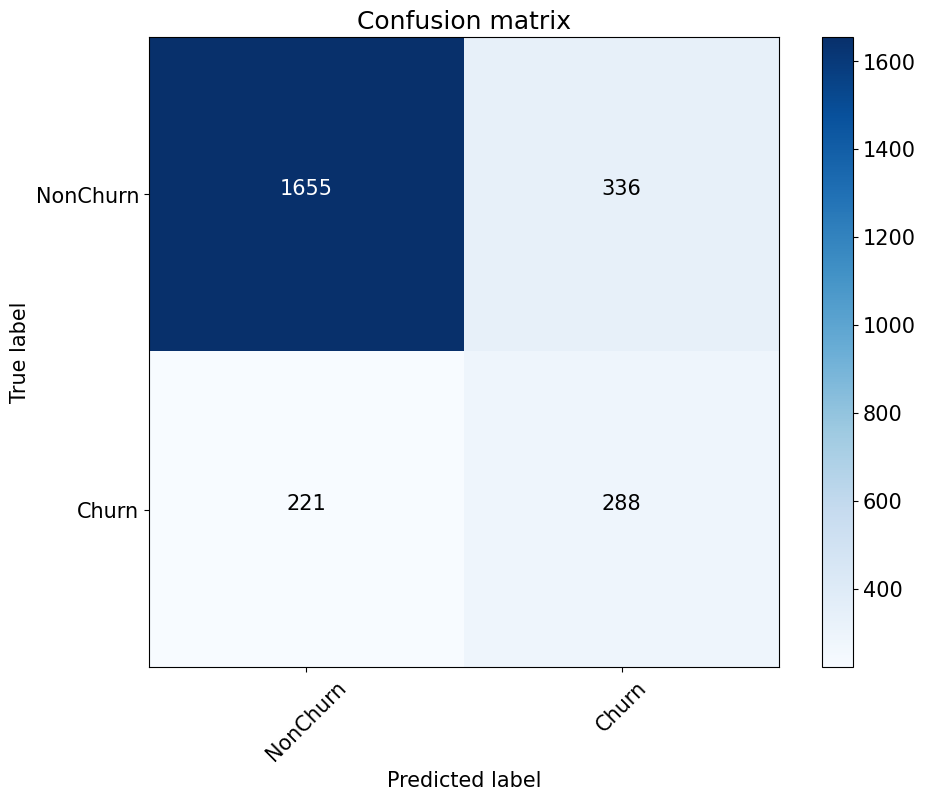

In [20]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [21]:
# добавим данные модели, полученной с помощью LogisticRegression
list_log_reg.append(precision[ix])
list_log_reg.append(recall[ix])
list_log_reg.append(fscore[ix])

## GradientBoostingClassifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 0)),
])

In [23]:
#обучим наш пайплайн
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', GradientBoostingClassifier(random_state=0))])

In [24]:
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]
preds_gb[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')

Best Threshold=0.4085078904556646, F-Score= 0.646, Precision= 0.704, Recall= 0.597


In [26]:
list_gradient_boosting.append(precision[ix])
list_gradient_boosting.append(recall[ix])
list_gradient_boosting.append(fscore[ix])

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


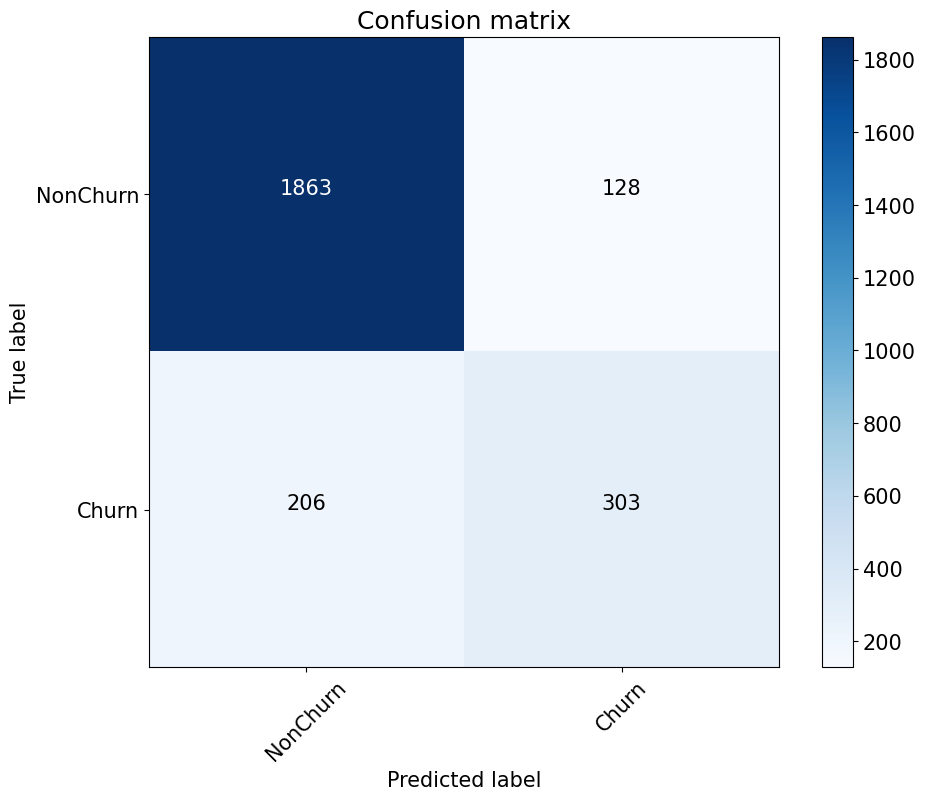

In [27]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gb>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### Сводная таблица по метрикам трех моделей:
#### - Logistic_Regression, Gradient_Boosting_Classifier (из домашнего задания)
#### - Random_Forest_Classifier (из лекции)

In [28]:
# добавим данные для сравнения метрик, полученные на модели RandomForestClassifier

list_random_forest.append(0.653)
list_random_forest.append(0.629)
list_random_forest.append(0.641)

In [29]:
list_pivot = []

list_pivot.append(list_log_reg)
list_pivot.append(list_gradient_boosting)
list_pivot.append(list_random_forest)

metrics_pivot = pd.DataFrame(list_pivot, columns=list_headlines, index=list_index).sort_values('f_score', ascending=False)
metrics_pivot

,precision,recall,f_score
Gradient_Boosting_Classifier,0.703704,0.59725,0.646121
Random_Forest_Classifier,0.653000,0.62900,0.641000
Logistic_Regression,0.462400,0.56778,0.509700


Вывод: Наиболее подходящей метрикой в данном случае явлется f-score, лучше по данной метрике показала себя модель - "Gradient Boosting Classifier"

## Расчет экономической до подбора гиперпараметров

1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного

Согласно матрицы ошибок моделей:

In [30]:
# Gradient Boosting Classifier

TP_GBC = 303   # правильно классифицированные
FP_GBC = 128
TN_GBC = 1863
FN_GBC = 206

# Random_Forest_Classifier

TP_RFC = 314   # правильно классифицированные
FP_RFC = 159
TN_RFC = 1832
FN_RFC = 195


# Logistic_Regression

TP_LR = 288  # правильно классифицированные
FP_LR = 336
TN_LR = 1655
FN_LR = 221

In [31]:
# расчеты

retain_sum_GBC = (FP_GBC + TP_GBC) * 1 # траты на удержание (модель Gradient Boosting Classifier)
retain_sum_RFC = (FP_RFC + TP_RFC) * 1 # траты на удержание (модель Random_Forest_Classifier)
retain_sum_LR = (FP_LR + TP_LR) * 1 # траты на удержание (модель Logistic_Regression)

income_GBC = TP_GBC * 2 # доход (модель Gradient Boosting Classifier)
income_RFC = TP_RFC * 2 # доход (модель Random_Forest_Classifier)
income_LR = TP_LR * 2 # доход (модель Logistic_Regression)

eff_GBC = income_GBC - retain_sum_GBC
eff_RFC = income_RFC - retain_sum_RFC
eff_LR = income_LR - retain_sum_LR 

list_name_columns_eff = ['доход', 'траты на удержание', 'прибыль']
list_index_ef = ['Logistic_Regression', 'Gradient_Boosting_Classifier', 'Random_Forest_Classifier'] # модели

retain_sum = []
income = []
eff = []
list_pivot_eff = []

list_GBC_ef = []
list_RFC_ef = []
list_LR_ef = []

list_GBC_ef.append(income_GBC)
list_GBC_ef.append(retain_sum_GBC)
list_GBC_ef.append(eff_GBC)

list_RFC_ef.append(income_RFC)
list_RFC_ef.append(retain_sum_RFC)
list_RFC_ef.append(eff_RFC)

list_LR_ef.append(income_LR)
list_LR_ef.append(retain_sum_LR)
list_LR_ef.append(eff_LR)


list_pivot_eff.append(list_GBC_ef)
list_pivot_eff.append(list_RFC_ef)
list_pivot_eff.append(list_LR_ef)

eff_pivot = pd.DataFrame(list_pivot_eff, columns=list_name_columns_eff, index=list_index_ef).sort_values('прибыль', ascending=False)
eff_pivot

,доход,траты на удержание,прибыль
Logistic_Regression,606,431,175
Gradient_Boosting_Classifier,628,473,155
Random_Forest_Classifier,576,624,-48


Вывод: Таким образом, по экономичесекой эффективности модель "Gradient Boosting Classifier" уступает "Logistic_Regression"

In [32]:
df_total = pd.concat([metrics_pivot, eff_pivot], axis=1)
df_total.sort_values('прибыль', ascending=False)

,precision,recall,f_score,доход,траты на удержание,прибыль
Logistic_Regression,0.462400,0.56778,0.509700,606,431,175
Gradient_Boosting_Classifier,0.703704,0.59725,0.646121,628,473,155
Random_Forest_Classifier,0.653000,0.62900,0.641000,576,624,-48
